In [1]:
%%html
<h2>Keras による LSTM実装</h2>
<ul>
  <li>サンプル2</li>
</ul>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(0)


def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)


def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise


'''
データの生成
'''
T = 100
f = toy_problem(T)

length_of_sequences = 2 * T
maxlen = 25  # ひとつの時系列データの長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train

X_train, X_validation, Y_train, Y_validation = \
    train_test_split(X, Y, test_size=N_validation)

'''
モデル設定
'''
n_in = len(X[0][0])  # 1
n_hidden = 30
n_out = len(Y[0])  # 1


def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()
model.add(LSTM(n_hidden,
               kernel_initializer=weight_variable,
               input_shape=(maxlen, n_in)))
model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('linear'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error',
              optimizer=optimizer)

'''
モデル学習
'''
epochs = 500
batch_size = 10

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_validation, Y_validation),
          callbacks=[early_stopping])

'''
出力を用いて予測
'''
truncate = maxlen
Z = X[:1]  # 元データの最初の一部だけ切り出し

original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_),
        axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))



Using TensorFlow backend.


Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 1s - loss: 0.5111 - val_loss: 0.4135
Epoch 2/500
158/158 [==============================] - 0s - loss: 0.4596 - val_loss: 0.3210
Epoch 3/500
158/158 [==============================] - 0s - loss: 0.3144 - val_loss: 0.2367
Epoch 4/500
158/158 [==============================] - 0s - loss: 0.2408 - val_loss: 0.1756
Epoch 5/500
158/158 [==============================] - 0s - loss: 0.1687 - val_loss: 0.1261
Epoch 6/500
158/158 [==============================] - 0s - loss: 0.1108 - val_loss: 0.0715
Epoch 7/500
158/158 [==============================] - 0s - loss: 0.0594 - val_loss: 0.0354
Epoch 8/500
158/158 [==============================] - 0s - loss: 0.0269 - val_loss: 0.0179
Epoch 9/500
158/158 [==============================] - 0s - loss: 0.0170 - val_loss: 0.0138
Epoch 10/500
158/158 [==============================] - 0s - loss: 0.0109 - val_loss: 0.0201
Epoch 11/500
158/158 [============

In [4]:
## 評価
# https://keras.io/ja/models/sequential/
score = model.evaluate(X_validation, Y_validation, batch_size=batch_size,verbose=0)
print("score:", score)

score: 0.00249852873902


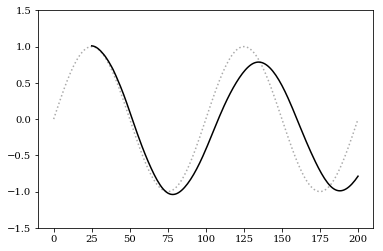

In [5]:
'''
グラフで可視化
'''
plt.rc('font', family='serif')
plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
#plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()
